In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys 
sys.path.insert(0, '../src/')
import jsm_mcmc_general
import jsm_SHMR
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

In [3]:
fid_theta = [1.95, -0.2, 10, 0.25, 0, 0]
priors = [[-2, 5],[-3, 2],[9,12],[0, 5],[-3,0],[-1, 1]]
params = ["a_1", "a_2", "a_3", "a_4", "a_5", "a_6"]
ndim = len(fid_theta)

reading in the data

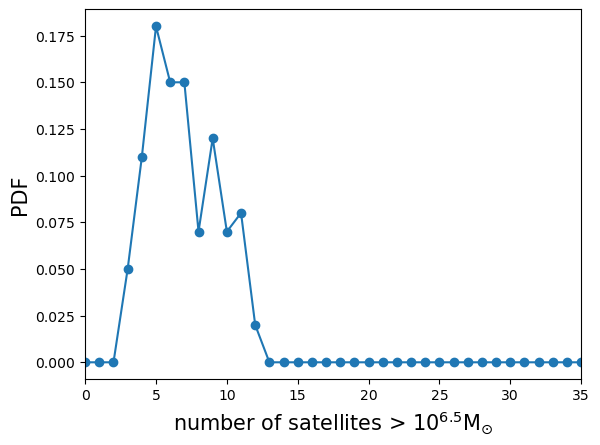

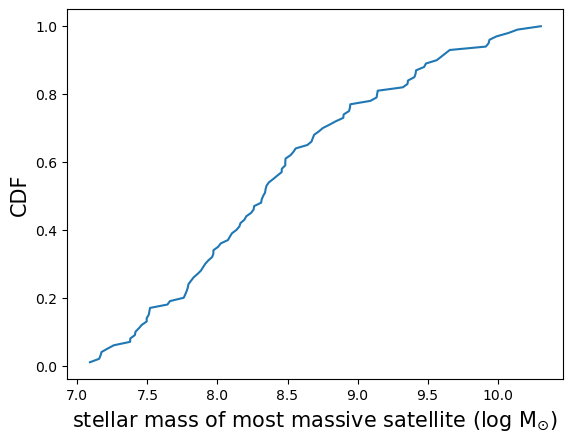

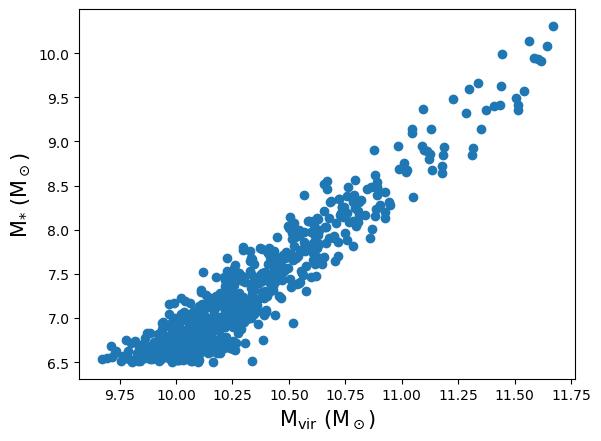

In [4]:
data = jsm_mcmc_general.init_data(fid_theta, "../../data/testing/redshift_sigma/master_data.npy")
data.get_stats(6.5, plot=True)
data.get_data_points(plot=True)

reading in the models. This is done only once!
(They don't include the SAGA index selected as "data")

In [5]:
models = jsm_mcmc_general.load_models("../../data/MW-analog/meta_data_psi3/", read_red=True)

In [6]:
def forward(theta):
    models.convert_zacc(theta, jsm_SHMR.redshift_sigmaGrow)
    models.get_stats(min_mass=6.5)
    return models.stat.Pnsat, models.stat.Msmax, models.stat.ecdf_MsMax

defining the log likelyhood

In [7]:
def lnlike(theta):
    model_Pnsat, models_Msmax, _ = forward(theta)
    lnL_sat = jsm_mcmc_general.lnL_Pnsat(model_Pnsat, data.stat.satfreq)
    lnL_max = jsm_mcmc_general.lnL_KS(models_Msmax, data.stat.Msmax)
    return lnL_sat + lnL_max

def lnprior(theta):
    if priors[0][0] < theta[0] < priors[0][1] and\
        priors[1][0] < theta[1] < priors[1][1] and\
         priors[3][0] < theta[3] < priors[3][1] and\
          priors[4][0] < theta[4] < priors[4][1] and\
           priors[5][0] < theta[5] < priors[5][1]:
        flatp = 0.0
    else:
        flatp = -np.inf
    gaussp = -( ((theta[2] - 10.0) / 0.2) ** 2 ) / 2
    return gaussp + flatp

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta)

intializing the run!

In [8]:
nwalk = 20
nsteps = 30
ndim = len(fid_theta)
datadir="../../data/testing/redshift_sigma/"

start_theta = [2, 0, 10, 0.25, -0.01, 0] # a somewhat random starting place

In [9]:
assert lnprior(start_theta) == 0.0

RUNNING!

In [10]:
mcmc_out = jsm_mcmc_general.RUN(start_theta, lnprob, nwalkers=nwalk, niter=nsteps, ndim=ndim)

Run took 108.7 seconds


saving the chain!
making some figures


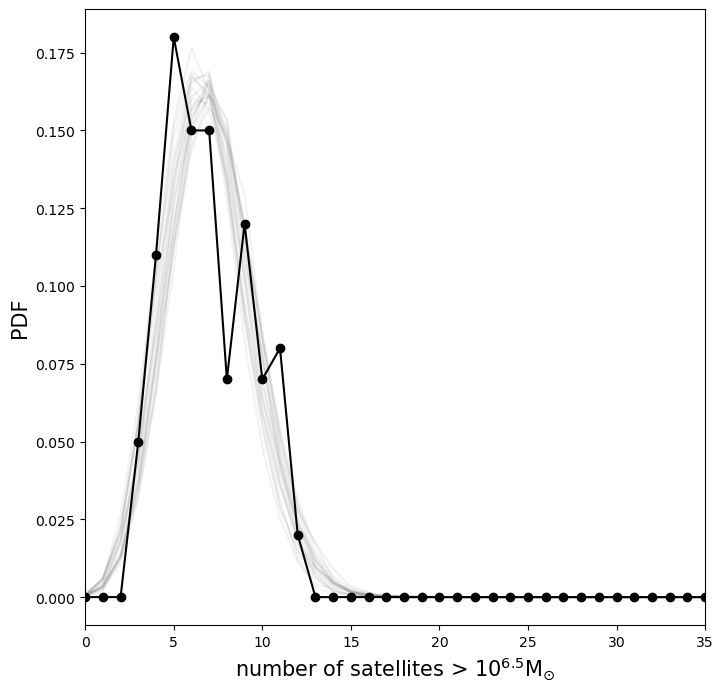

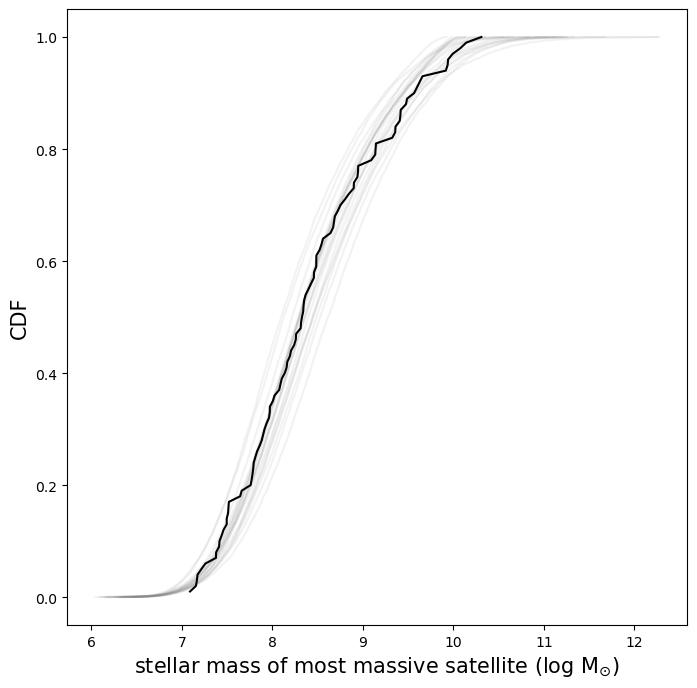

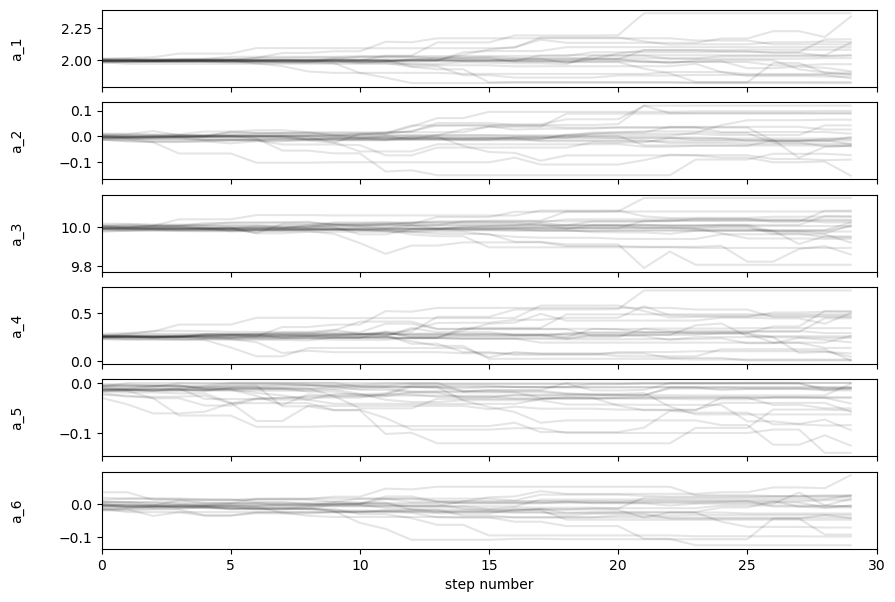

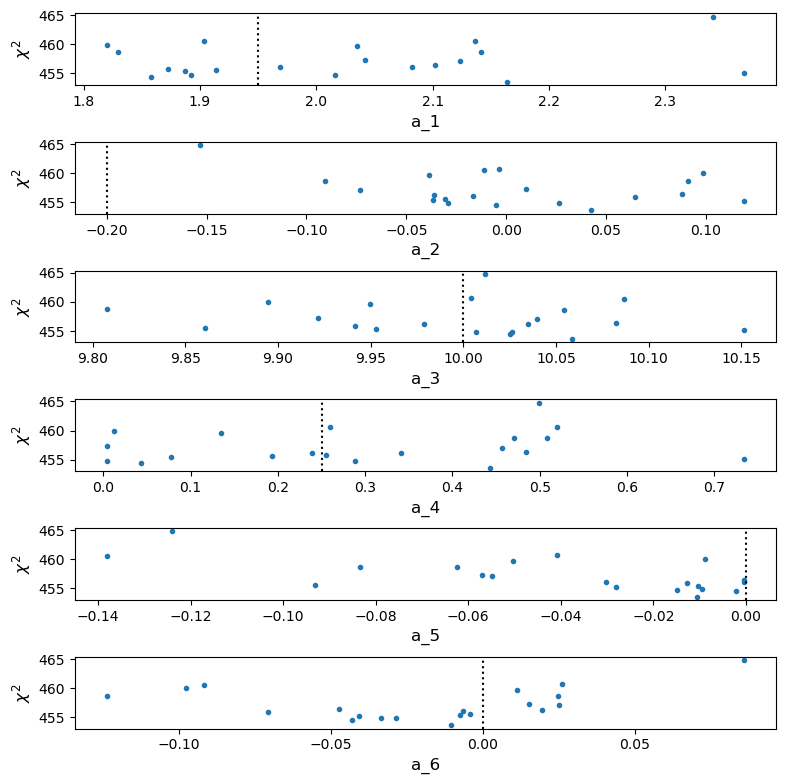

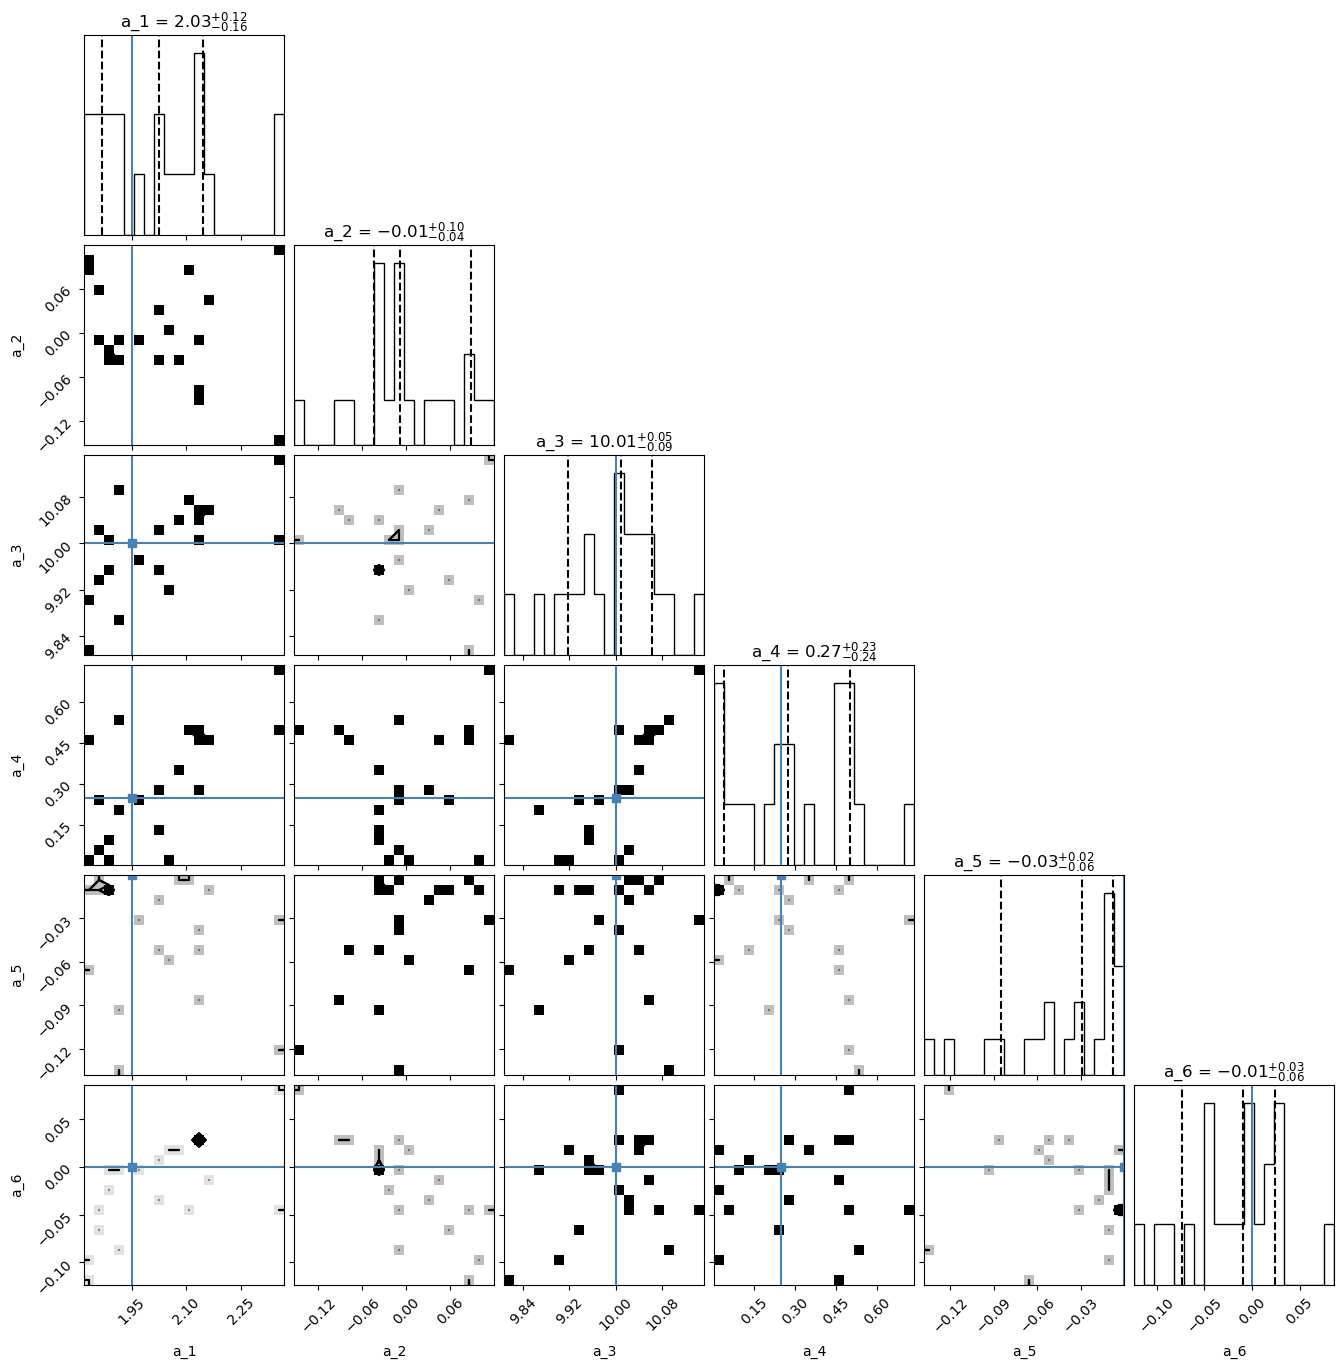

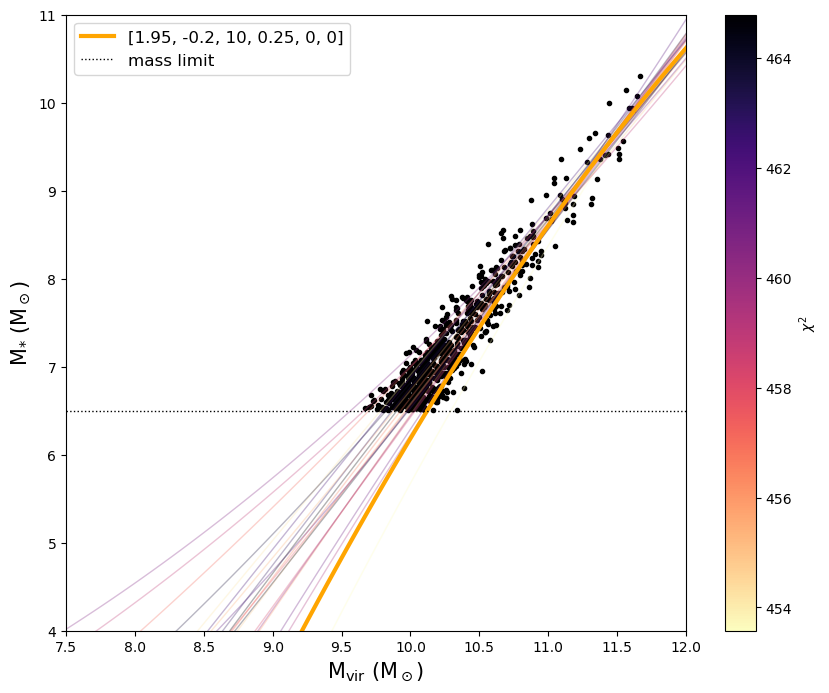

In [11]:
test = jsm_mcmc_general.inspect_run(mcmc_out, data=data, forward=forward, start_theta=start_theta, labels=params, priors=priors, savedir=datadir, min_mass=6.5, a_stretch=2.3)